# Group_23
# Reg: **2022331005** & **2022331093**

# **Predicting the Winners of the Champions League Football Tournament**

<div style="text-align:center;">
    <img src="winners-prev.png" alt="Past Winners" width="1050"/>
</div>


<div style="text-align:center;">
    Past UCL winners
</div>

## ESSENTIAL IMPORTS

In [355]:
import pandas as pd
import numpy as np
from IPython.display import display 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore', category=UserWarning)   


# ML tools

In [356]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


# Models

In [357]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Oversampler

In [358]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# ENHANCEMENT: Storage for Comparison

In [359]:

results = {}
best_models = {}

# Data Collection


UEFA Champions League: Data Strategy & Context
Reference: https://www.uefa.com/uefachampionsleague/history/seasons/1992/

Here is the logic behind the dataset selection:

Why 1992? We are starting the data collection in 1992 because that marks the rebranding of the European Cup to the current UEFA Champions League. While the competition existed before, the 1992 changes created the modern format we know today. Using data prior to this might introduce inconsistencies, so 1992 is the cleanest starting point for a robust model.

Data Split

• Training Set (1992 – 2020): We will use the bulk of the modern era history to train the model on established trends.

• Prediction Set (2021 – 2024): The most recent seasons are reserved for the final validation to test the model's accuracy on current data.

In [360]:

data = pd.read_csv("ucl_stats.csv")
print(data)

     year                    team  match_played  wins  draws  losts  \
0    1993               Marseille             6     3      3      0   
1    1993                   Milan             7     6      0      1   
2    1993                 Rangers             6     2      4      0   
3    1993             Club Brugge             6     2      1      3   
4    1993             CSKA Moscow             6     0      2      4   
..    ...                     ...           ...   ...    ...    ...   
709  2020  Zenit Saint Petersburg             6     2      1      3   
710  2020                Valencia             8     3      2      3   
711  2020                 Chelsea             8     3      2      3   
712  2020                    Ajax             6     3      1      2   
713  2020                   Lille             6     0      1      5   

     goals_scored  goals_conceded  gd  group_point  champions  
0              14               4  10            9          1  
1              11  

In [361]:
data.head()

,year,team,match_played,wins,draws,losts,goals_scored,goals_conceded,gd,group_point,champions
0,1993,Marseille,6,3,3,0,14,4,10,9,1
1,1993,Milan,7,6,0,1,11,2,9,12,0
2,1993,Rangers,6,2,4,0,7,5,2,8,0
3,1993,Club Brugge,6,2,1,3,5,8,-3,5,0
4,1993,CSKA Moscow,6,0,2,4,2,11,-9,2,0


In [362]:
data.tail()

,year,team,match_played,wins,draws,losts,goals_scored,goals_conceded,gd,group_point,champions
709,2020,Zenit Saint Petersburg,6,2,1,3,7,9,-2,7,0
710,2020,Valencia,8,3,2,3,13,15,-2,11,0
711,2020,Chelsea,8,3,2,3,12,16,-4,11,0
712,2020,Ajax,6,3,1,2,12,6,6,10,0
713,2020,Lille,6,0,1,5,4,14,-10,1,0


In [363]:
print(f"shape: {data.shape}")

shape: (714, 11)


In [364]:
string_cols=data.select_dtypes(include=['object']).columns
for col in string_cols:
    print(f"{col}: {data[col].unique()}")

team: ['Marseille' 'Milan' 'Rangers' 'Club Brugge' 'CSKA Moscow' 'IFK Goteborg'
 ' Porto' 'PSV Eindhoven' ' Spartak Moscow' ' Galatasaray' 'Werder Bremen'
 'Anderlecht' 'Porto' 'Monaco' 'Barcelona' 'Manchester United'
 'Galatasaray' 'Spartak Moscow' 'Dynamo Kyiv' 'Steaua Bucure?ti'
 'Casino Salzburg' 'AEK Athens' 'Paris Saint-Germain' 'Bayern Munich'
 ' Benfica' 'Hajduk Split' 'Ajax' 'Panathinaikos' 'Nantes' 'Aalborg BK'
 'Legia Warsaw' 'Rosenborg' 'Blackburn Rovers' 'Juventus'
 'Borussia Dortmund' 'Real Madrid' 'Ferencvaros' 'Grasshopper' 'Auxerre'
 'Atletico Madrid' 'Rapid Wien' 'Parma' 'Sparta Prague' 'Feyenoord'
 'Newcastle United' 'Olympiacos' 'Besiktas' 'Bayer Leverkusen'
 'Sporting CP' 'Lierse' 'Croatia Zagreb' ' Juventus' 'Athletic Bilbao'
 'Internazionale' 'Sturm Graz' 'Arsenal' 'Lens' 'Kaiserslautern' 'Benfica'
 'HJK' 'Hertha BSC' 'Valencia' 'Fiorentina' 'Bordeaux' 'Lazio' 'Chelsea'
 'Deportivo La Coruna' 'Lyon' 'Leeds United' 'Boavista' 'Liverpool' 'Roma'
 'Lokomotiv Moscow'

In [365]:
# View available columns and related info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            714 non-null    int64 
 1   team            714 non-null    object
 2   match_played    714 non-null    int64 
 3   wins            714 non-null    int64 
 4   draws           714 non-null    int64 
 5   losts           714 non-null    int64 
 6   goals_scored    714 non-null    int64 
 7   goals_conceded  714 non-null    int64 
 8   gd              714 non-null    int64 
 9   group_point     714 non-null    int64 
 10  champions       714 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 61.5+ KB


In [366]:
# Quick view of descriptive statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,714.0,2008.711485,7.340121,1993.0,2004.0,2009.0,2015.0,2020.0
match_played,714.0,7.673669,2.100880,6.0,6.0,6.0,8.0,13.0
wins,714.0,2.939776,2.316600,0.0,1.0,2.0,4.0,11.0
draws,714.0,1.844538,1.273169,0.0,1.0,2.0,3.0,7.0
losts,714.0,2.892157,1.234552,0.0,2.0,3.0,4.0,6.0
goals_scored,714.0,10.582633,6.979194,0.0,5.0,9.0,14.0,43.0
goals_conceded,714.0,10.443978,3.634080,2.0,8.0,10.0,13.0,24.0
gd,714.0,0.198880,7.573646,-22.0,-5.0,0.0,5.0,35.0
group_point,714.0,8.183473,4.192922,-8.0,5.0,8.0,11.0,18.0
champions,714.0,0.039216,0.194244,0.0,0.0,0.0,0.0,1.0


# Data Cleaning

In [367]:
# Check for missing values
data.isna().sum()  

year              0
team              0
match_played      0
wins              0
draws             0
losts             0
goals_scored      0
goals_conceded    0
gd                0
group_point       0
champions         0
dtype: int64

In [368]:
# Check for duplicates
duplicates = data[data.duplicated()]
print("Number of duplicates: ", len(duplicates))

Number of duplicates:  0


In [369]:
#trims whitespace
data['team'] = data['team'].str.strip()

In [370]:
# Function to handle any possible inconsistencies in our dataset
def fix_inconsistencies(data):
    # Ensure that matches played = wins + draws + losses
    data = data[data['wins'] + data['draws'] + data['losts'] == data['match_played']]
    
    # Check that Goal Diff = Goals For - Goals Against
    data = data[data['goals_scored'] - data['goals_conceded'] == data['gd']]
    
    return data

cleaned_df = fix_inconsistencies(data.copy()) # Using a copy of the original data set
cleaned_df

,year,team,match_played,wins,draws,losts,goals_scored,goals_conceded,gd,group_point,champions
0,1993,Marseille,6,3,3,0,14,4,10,9,1
1,1993,Milan,7,6,0,1,11,2,9,12,0
2,1993,Rangers,6,2,4,0,7,5,2,8,0
3,1993,Club Brugge,6,2,1,3,5,8,-3,5,0
4,1993,CSKA Moscow,6,0,2,4,2,11,-9,2,0
...,...,...,...,...,...,...,...,...,...,...,...
709,2020,Zenit Saint Petersburg,6,2,1,3,7,9,-2,7,0
710,2020,Valencia,8,3,2,3,13,15,-2,11,0
711,2020,Chelsea,8,3,2,3,12,16,-4,11,0
712,2020,Ajax,6,3,1,2,12,6,6,10,0


In [371]:
corr=data.corr(numeric_only=True)
print(corr.round(3))

                 year  match_played   wins  draws  losts  goals_scored  \
year            1.000         0.060  0.049 -0.080  0.085         0.119   
match_played    0.060         1.000  0.882  0.355 -0.332         0.832   
wins            0.049         0.882  1.000  0.111 -0.491         0.882   
draws          -0.080         0.355  0.111  1.000 -0.625         0.213   
losts           0.085        -0.332 -0.491 -0.625  1.000        -0.464   
goals_scored    0.119         0.832  0.882  0.213 -0.464         1.000   
goals_conceded  0.221         0.046 -0.138 -0.184  0.526         0.076   
gd              0.004         0.738  0.870  0.282 -0.672         0.873   
group_point     0.047         0.701  0.865  0.212 -0.650         0.764   
champions      -0.061         0.399  0.404  0.155 -0.257         0.397   

                goals_conceded     gd  group_point  champions  
year                     0.221  0.004        0.047     -0.061  
match_played             0.046  0.738        0.701      0

# Descriptive Statistics

In [372]:
num_cols=["year", "match_played", "wins", "draws", "losts", "goals_scored", "goals_conceded", "gd", "group_point", "champions"]


In [373]:
print("Skewness of each column:")
print(data[num_cols].skew())

Skewness of each column:
year             -0.292574
match_played      1.067313
wins              0.864137
draws             0.690167
losts             0.192457
goals_scored      1.250151
goals_conceded    0.462985
gd                0.572069
group_point      -0.083664
champions         4.757718
dtype: float64


In [374]:
print("\nKurtosis of each column:")
print(data[num_cols].kurtosis())


Kurtosis of each column:
year              -0.916990
match_played       0.055671
wins               0.285389
draws              0.780566
losts             -0.125295
goals_scored       1.879041
goals_conceded     0.242339
gd                 1.069469
group_point       -0.570018
champions         20.693839
dtype: float64


# Feature Selection/Engineering


In [375]:
# Rename features
df = cleaned_df 
df = df.rename(columns={'match_played': 'matches_played', 'losts': 'losses', 'gd': 'goal_diff'})
df.head()

,year,team,matches_played,wins,draws,losses,goals_scored,goals_conceded,goal_diff,group_point,champions
0,1993,Marseille,6,3,3,0,14,4,10,9,1
1,1993,Milan,7,6,0,1,11,2,9,12,0
2,1993,Rangers,6,2,4,0,7,5,2,8,0
3,1993,Club Brugge,6,2,1,3,5,8,-3,5,0
4,1993,CSKA Moscow,6,0,2,4,2,11,-9,2,0


In [376]:
# Drop unnecessary features
df.drop(['year'], axis = 1, inplace = True)
df

,team,matches_played,wins,draws,losses,goals_scored,goals_conceded,goal_diff,group_point,champions
0,Marseille,6,3,3,0,14,4,10,9,1
1,Milan,7,6,0,1,11,2,9,12,0
2,Rangers,6,2,4,0,7,5,2,8,0
3,Club Brugge,6,2,1,3,5,8,-3,5,0
4,CSKA Moscow,6,0,2,4,2,11,-9,2,0
...,...,...,...,...,...,...,...,...,...,...
709,Zenit Saint Petersburg,6,2,1,3,7,9,-2,7,0
710,Valencia,8,3,2,3,13,15,-2,11,0
711,Chelsea,8,3,2,3,12,16,-4,11,0
712,Ajax,6,3,1,2,12,6,6,10,0


### Evaluating Other factors

In [377]:
leagues = {
    "LaLiga": ["Barcelona", "Real Madrid", "Atletico Madrid", "Valencia", "Deportivo La Coruna", "Real Sociedad", "Celta Vigo", "Villarreal", "Real Betis", "Sevilla", "Malaga" ],
    "Premier": ["Manchester United", "Blackburn Rovers", "Newcastle United", "Chelsea", "Leeds United", "Liverpool", "Tottenham Hotspur", "Manchester City", "Leicester City"],
    "Bundesliga": ["Werder Bremen", "Bayern Munich", "Borussia Dortmund", "Bayer Leverkusen", "Hertha BSC", "Stuttgart", "Schalke 04", "Hamburg", "Wolfsburg", "Borussia Monchengladbach", "RB Leipzig", "1899 Hoffenheim"],
    "Ligue1": ["Marseille", "Monaco", "Paris Saint-Germain", "Nantes", "Auxerre", "Bordeaux", "Lyon", "Lille", "Montpellier"],
    "SerieA": ["Milan", "Juventus", "Parma", "Fiorentina", "Lazio", "Roma", "Udinese", "Napoli", "Inter Milan", "Atalanta"],
    "Misc": ["Rangers", "Club Brugge", "CSKA Moscow", "IFK Goteborg", "Porto", "PSV Eindhoven", "Spartak Moscow", "Galatasaray", "Anderlecht", "Dynamo Kyiv", "Steaua Bucure?ti", "Casino Salzburg", "AEK Athens", "Benfica", "Hajduk Split", "Ajax", "Panathinaikos", "Aalborg BK", "Legia Warsaw", "Rosenborg", "Ferencvaros", "Grasshopper", "Rapid Wien", "Sparta Prague", "Feyenoord", "Olympiacos", "Besiktas", "Sporting CP", "Lierse", "Croatia Zagreb", "Sturm Graz", "HJK", "Boavista", "Lokomotiv Moscow", "Basel", "Celtic", "Partizan", "Maccabi Tel Aviv", "Fenerbahce", "Shakhtar Donetsk", "Thun", "Artmedia", "Levski Sofia", "Copenhagen", "Be?ikta?", "Slavia Prague", "CFR Cluj", "Anorthosis", "PSV", "Zenit Saint Petersburg", "BATE Borisov", "Maccabi Haifa", "Zurich", "APOEL", "Debrecen", "Rubin Kazan", "Unirea Urziceni", "Standard Liege", "AZ", "Twente", "Hapoel Tel Aviv", "Bursaspor", "Braga", "Trabzonspor", "O?elul Gala?i", "Dinamo Zagreb", "Genk", "Viktoria Plze?", "Nordsjaelland", "Austria Wien", "Ludogorets Razgrad", "Maribor", "Astana", "Gent", "Be?ikta?", "Rostov", "Qaraba?", "Red Star Belgrade", "Young Boys", "Red Bull Salzburg"],
}

df['league'] = ''

for league, teams in leagues.items():
    df.loc[df['team'].isin(teams), 'league'] = league

df

,team,matches_played,wins,draws,losses,goals_scored,goals_conceded,goal_diff,group_point,champions,league
0,Marseille,6,3,3,0,14,4,10,9,1,Ligue1
1,Milan,7,6,0,1,11,2,9,12,0,SerieA
2,Rangers,6,2,4,0,7,5,2,8,0,Misc
3,Club Brugge,6,2,1,3,5,8,-3,5,0,Misc
4,CSKA Moscow,6,0,2,4,2,11,-9,2,0,Misc
...,...,...,...,...,...,...,...,...,...,...,...
709,Zenit Saint Petersburg,6,2,1,3,7,9,-2,7,0,Misc
710,Valencia,8,3,2,3,13,15,-2,11,0,LaLiga
711,Chelsea,8,3,2,3,12,16,-4,11,0,Premier
712,Ajax,6,3,1,2,12,6,6,10,0,Misc


In [378]:
# Build new Ratio features
df['Win_Ratio'] = (df['wins']) / df['matches_played']
df['Loss_Ratio'] = (df['losses']) / df['matches_played']
df['GoalsScored_to_Matches'] = (df['goals_scored']) / df['matches_played']
df['GoalsConceeded_to_Matches'] = (df['goals_conceded']) / df['matches_played']
df['Win_to_Loss'] = (df['wins']) / (df['losses'] + 1)
df['Wins_to_GoalsScored'] = (df['wins']) / (df['goals_scored'] + 1) 
df['GoalsScored_GoalsConceded'] = (df['goals_scored'] - df['goals_conceded'])

df

,team,matches_played,wins,draws,losses,goals_scored,goals_conceded,goal_diff,group_point,champions,league,Win_Ratio,Loss_Ratio,GoalsScored_to_Matches,GoalsConceeded_to_Matches,Win_to_Loss,Wins_to_GoalsScored,GoalsScored_GoalsConceded
0,Marseille,6,3,3,0,14,4,10,9,1,Ligue1,0.500000,0.000000,2.333333,0.666667,3.00,0.200000,10
1,Milan,7,6,0,1,11,2,9,12,0,SerieA,0.857143,0.142857,1.571429,0.285714,3.00,0.500000,9
2,Rangers,6,2,4,0,7,5,2,8,0,Misc,0.333333,0.000000,1.166667,0.833333,2.00,0.250000,2
3,Club Brugge,6,2,1,3,5,8,-3,5,0,Misc,0.333333,0.500000,0.833333,1.333333,0.50,0.333333,-3
4,CSKA Moscow,6,0,2,4,2,11,-9,2,0,Misc,0.000000,0.666667,0.333333,1.833333,0.00,0.000000,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,Zenit Saint Petersburg,6,2,1,3,7,9,-2,7,0,Misc,0.333333,0.500000,1.166667,1.500000,0.50,0.250000,-2
710,Valencia,8,3,2,3,13,15,-2,11,0,LaLiga,0.375000,0.375000,1.625000,1.875000,0.75,0.214286,-2
711,Chelsea,8,3,2,3,12,16,-4,11,0,Premier,0.375000,0.375000,1.500000,2.000000,0.75,0.230769,-4
712,Ajax,6,3,1,2,12,6,6,10,0,Misc,0.500000,0.333333,2.000000,1.000000,1.00,0.230769,6


In [379]:
# Encode categorical columns
df['team'] = df['team'].astype('category').cat.codes
df['league'] = df['league'].astype('category').cat.codes
df

,team,matches_played,wins,draws,losses,goals_scored,goals_conceded,goal_diff,group_point,champions,league,Win_Ratio,Loss_Ratio,GoalsScored_to_Matches,GoalsConceeded_to_Matches,Win_to_Loss,Wins_to_GoalsScored,GoalsScored_GoalsConceded
0,82,6,3,3,0,14,4,10,9,1,3,0.500000,0.000000,2.333333,0.666667,3.00,0.200000,10
1,83,7,6,0,1,11,2,9,12,0,6,0.857143,0.142857,1.571429,0.285714,3.00,0.500000,9
2,101,6,2,4,0,7,5,2,8,0,4,0.333333,0.000000,1.166667,0.833333,2.00,0.250000,2
3,38,6,2,1,3,5,8,-3,5,0,4,0.333333,0.500000,0.833333,1.333333,0.50,0.333333,-3
4,33,6,0,2,4,2,11,-9,2,0,4,0.000000,0.666667,0.333333,1.833333,0.00,0.000000,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,135,6,2,1,3,7,9,-2,7,0,4,0.333333,0.500000,1.166667,1.500000,0.50,0.250000,-2
710,129,8,3,2,3,13,15,-2,11,0,2,0.375000,0.375000,1.625000,1.875000,0.75,0.214286,-2
711,37,8,3,2,3,12,16,-4,11,0,5,0.375000,0.375000,1.500000,2.000000,0.75,0.230769,-4
712,5,6,3,1,2,12,6,6,10,0,4,0.500000,0.333333,2.000000,1.000000,1.00,0.230769,6


In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 685 entries, 0 to 713
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   team                       685 non-null    int16  
 1   matches_played             685 non-null    int64  
 2   wins                       685 non-null    int64  
 3   draws                      685 non-null    int64  
 4   losses                     685 non-null    int64  
 5   goals_scored               685 non-null    int64  
 6   goals_conceded             685 non-null    int64  
 7   goal_diff                  685 non-null    int64  
 8   group_point                685 non-null    int64  
 9   champions                  685 non-null    int64  
 10  league                     685 non-null    int8   
 11  Win_Ratio                  685 non-null    float64
 12  Loss_Ratio                 685 non-null    float64
 13  GoalsScored_to_Matches     685 non-null    float64
 14 

# Statistical Testing

In [381]:
# Shapiro-Wilk Test

shapiro_stat, shapiro_p_value = stats.shapiro(df['Win_Ratio'])

print(f"--- Shapiro-Wilk Test for 'Win_Ratio' ---")
print(f"Statistic: {shapiro_stat:.3f}")
print(f"P-value: {shapiro_p_value:.3e}") 

if shapiro_p_value > 0.05:
    print("Conclusion: The data is likely normally distributed.")
else:
    print("Conclusion: The data is NOT normally distributed.")

--- Shapiro-Wilk Test for 'Win_Ratio' ---
Statistic: 0.956
P-value: 1.591e-13
Conclusion: The data is NOT normally distributed.


In [382]:
# Anderson-Darling Test

result = stats.anderson(df['Win_Ratio'], dist='norm') # Test against a normal distribution

print(f"\n--- Anderson-Darling Test for 'points' ---")
print(f"Statistic: {result.statistic:.3f}")

# The test returns critical values for 15%, 10%, 5%, 2.5%, 1%
# We are usually most interested in the 5% level
print(f"Critical Values: {result.critical_values}")

# Check against the 5% critical value (which is the 3rd one in the list)
if result.statistic < result.critical_values[2]:
    print("Conclusion: The data is likely normal (at 5% significance).")
else:
    print("Conclusion: The data is NOT normal (at 5% significance).")


--- Anderson-Darling Test for 'points' ---
Statistic: 10.399
Critical Values: [0.573 0.652 0.782 0.913 1.086]
Conclusion: The data is NOT normal (at 5% significance).


In [383]:
# T-Test (Independent Two-Sample)

champion_group = df[df['champions'] == 1]['Win_Ratio'].dropna()
non_champion_group = df[df['champions'] == 0]['Win_Ratio'].dropna()


t_stat, p_value = stats.ttest_ind(champion_group, non_champion_group, equal_var=False)

print(f"\n--- T-Test: Champion vs. Non-Champion 'Win_Ratio' ---")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3e}")

if p_value < 0.05:
    print("Conclusion: There IS a significant difference in average Win_Ratio.")
else:
    print("Conclusion: There is NO significant difference in average Win_Ratio.")


--- T-Test: Champion vs. Non-Champion 'Win_Ratio' ---
T-statistic: 12.127
P-value: 2.735e-13
Conclusion: There IS a significant difference in average Win_Ratio.


# Some Graphichal representation

In [384]:
numeric_cols = [
    'match_played', 'wins', 'draws', 'losts',
    'goals_scored', 'goals_conceded', 'gd',
    'group_point', 'champions'
]

In [385]:
cleaned_df

,year,team,match_played,wins,draws,losts,goals_scored,goals_conceded,gd,group_point,champions
0,1993,Marseille,6,3,3,0,14,4,10,9,1
1,1993,Milan,7,6,0,1,11,2,9,12,0
2,1993,Rangers,6,2,4,0,7,5,2,8,0
3,1993,Club Brugge,6,2,1,3,5,8,-3,5,0
4,1993,CSKA Moscow,6,0,2,4,2,11,-9,2,0
...,...,...,...,...,...,...,...,...,...,...,...
709,2020,Zenit Saint Petersburg,6,2,1,3,7,9,-2,7,0
710,2020,Valencia,8,3,2,3,13,15,-2,11,0
711,2020,Chelsea,8,3,2,3,12,16,-4,11,0
712,2020,Ajax,6,3,1,2,12,6,6,10,0


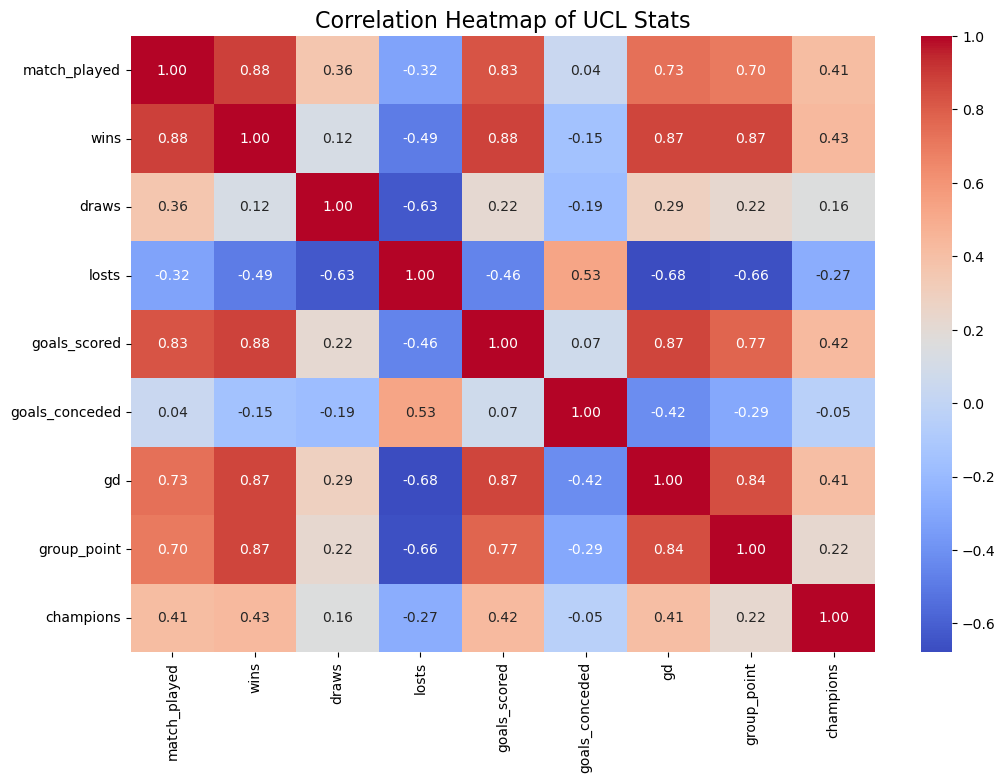

In [386]:
corr_matrix =cleaned_df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of UCL Stats', fontsize=16)
plt.show()

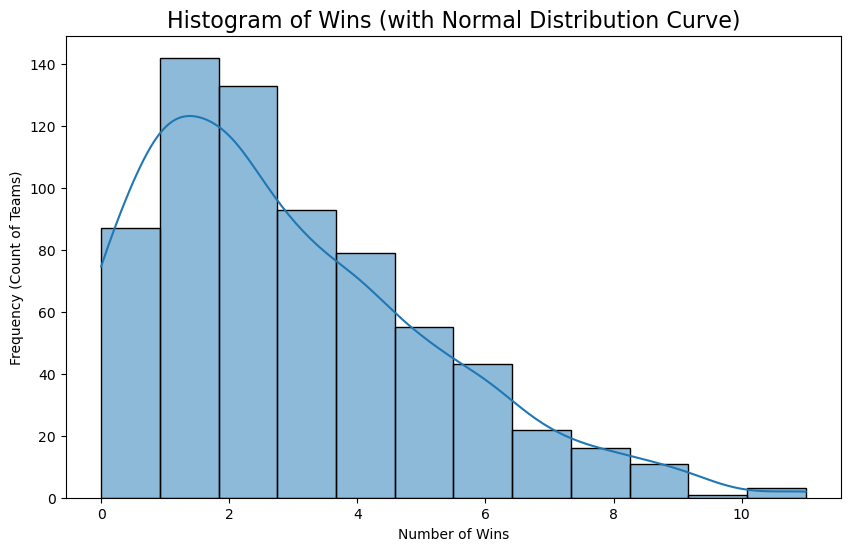

In [387]:
#plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_df['wins'], kde=True, bins=12)
plt.title('Histogram of Wins (with Normal Distribution Curve)', fontsize=16)
plt.xlabel('Number of Wins')
plt.ylabel('Frequency (Count of Teams)')
plt.show()

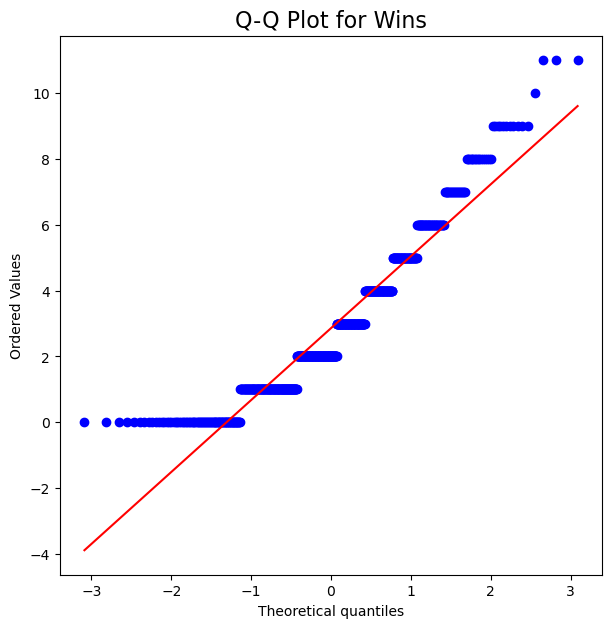

In [388]:
# q-q plot
plt.figure(figsize=(7, 7))
stats.probplot(cleaned_df['wins'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Wins', fontsize=16)
plt.show()

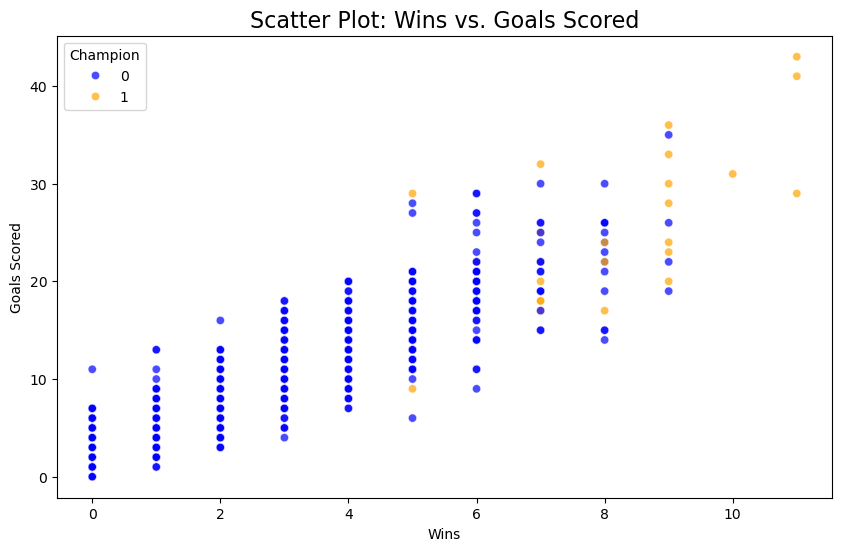

In [389]:
# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_df, x='wins', y='goals_scored', hue='champions', palette={0: 'blue', 1: 'orange'}, alpha=0.7)
plt.title('Scatter Plot: Wins vs. Goals Scored', fontsize=16)
plt.xlabel('Wins')
plt.ylabel('Goals Scored')
plt.legend(title='Champion')
plt.show()

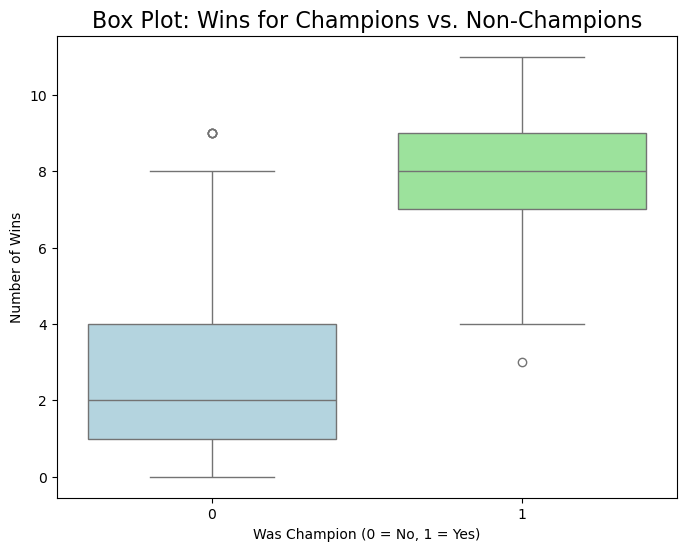

In [390]:
# Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=cleaned_df, x='champions', y='wins', hue='champions', legend=False, palette={0: 'lightblue', 1: 'lightgreen'})
plt.title('Box Plot: Wins for Champions vs. Non-Champions', fontsize=16)
plt.xlabel('Was Champion (0 = No, 1 = Yes)')
plt.ylabel('Number of Wins')
plt.show()

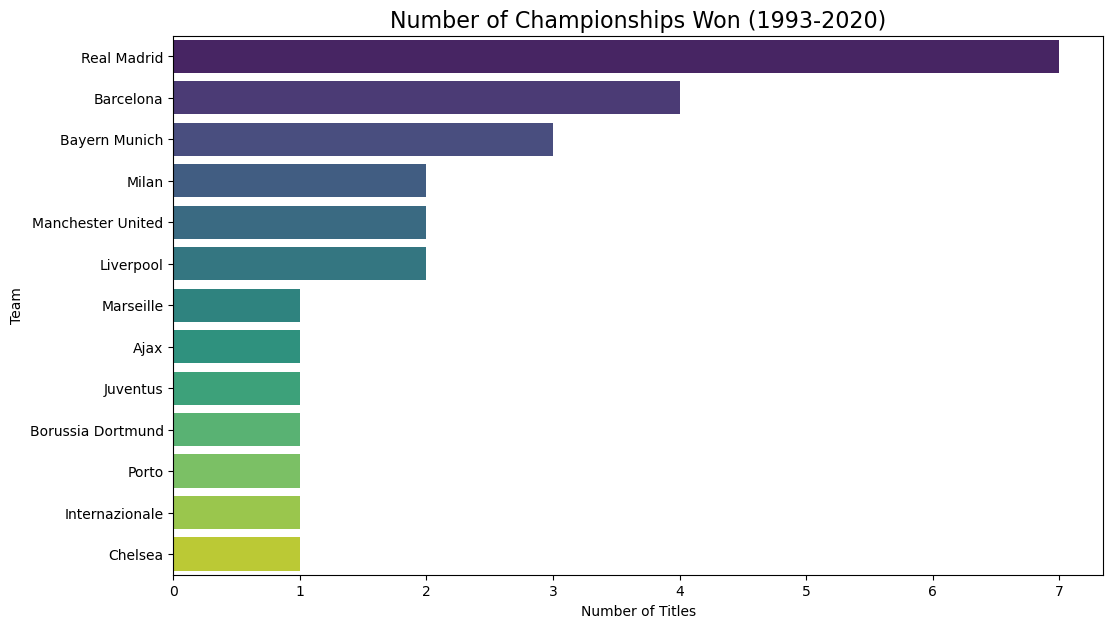

In [391]:
# Bar Plot
# Filter for champions and count them by team
champion_counts = cleaned_df[cleaned_df['champions'] == 1]['team'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=champion_counts.values, y=champion_counts.index, hue=champion_counts.index, legend=False, palette='viridis')
plt.title('Number of Championships Won (1993-2020)', fontsize=16)
plt.xlabel('Number of Titles')
plt.ylabel('Team')
plt.show()

### Feature Correlation

Now that we have all our intended features ready to go, we can analyze the correlations that exist among these features as well the the relationships between the individual features and the target variable. One great way to do this is using a correlation matrix. This provides a neat visual to explore these existing relationships. To use this, we make use of the Seaborn package's `heatmap` function. 

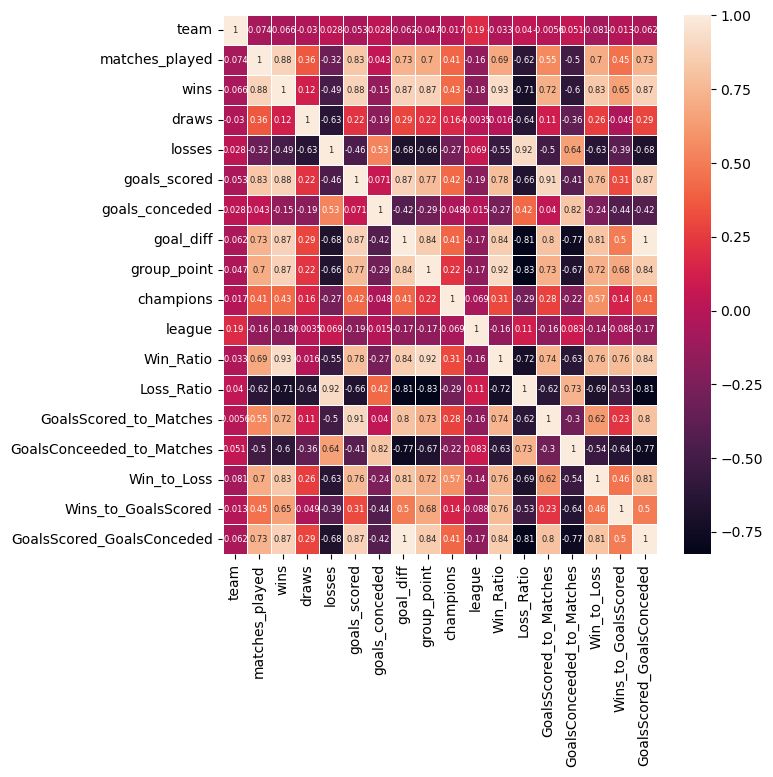

In [392]:
features = df.columns.tolist()
correlation = df[features].corr()
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(correlation, annot=True, annot_kws={"size": 6}, linewidths=0.5)
df = pd.read_csv("ucl_stats.csv")
plt.show()


### Train/Test Split

We decided to use the Test set cross validation method for training our model.This involves splitting our dataset into training and testing sets, training the model on the training setand evaluating its performance on the test set. We want to give the model as much data as possible to train with. However, we also want to make sure that we have enough data for the model to test itself on.

We split our data using the scikit-learn `train_test_split` function. In our case, since our dataset, we  is not very large, we chose 80% of the overall dataset for our training data and 20% for the test set to be somewhat fair to both training and testing. We set `stratify=y` to ensure that both the train and test sets have the same proportion of of the 0s and 1s in the target variable, `champions` as the original dataset.

In [393]:
X = df.drop(columns=["champions", "team", "year"])
y = df["champions"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [394]:

# neg_count and pos_count calculations from your snippet:
neg_count = y.value_counts().get(0, 0) 
pos_count = y.value_counts().get(1, 0) 
scale_pos_weight_value = neg_count / pos_count

print(f"Target Imbalance: Non-Champions ({neg_count}) vs Champions ({pos_count})")
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")



Target Imbalance: Non-Champions (686) vs Champions (28)
Calculated scale_pos_weight: 24.50


In [395]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()


# Preprocessing pipeline

In [396]:
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])


# Modelling

For modelling, we will explore two of the machine learning models.
- **Random Forest:** Probably the best model to use for this, random forests handle complex relationships and interactions between features and its ensemble nature helps in reducing overfitting and capturing the underlying patterns effectively. Given the complex nature of football data and the potential non-linear relationships between performance metrics and winning, Random Forest can capture these complexities effectively.
- **XGBoost (Extreme Gradient Boosting):** This is a powerful and highly efficient gradient boosting framework that has become a top choice for structured data problems, often outperforming Random Forest in predictive accuracy. It works by sequentially building an ensemble of weak prediction models (typically decision trees), where each new model corrects the residual errors made by the previous ones. Given the large volume and high dimensionality of football data, XGBoost's speed, ability to handle sparse data, and built-in regularization features (which prevent overfitting) make it excellent for modeling complex, non-linear dependencies between performance metrics and match outcomes.




# **Random Forest**

In [397]:

rf = RandomForestClassifier(random_state=42)
rf_params = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [5, 10],
    "model__class_weight": ["balanced", None] }

# **XGBoost**

In [398]:

xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
)

xgb_params = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.05, 0.1],
    "model__scale_pos_weight": [scale_pos_weight_value * 0.9, scale_pos_weight_value, scale_pos_weight_value * 1.1] }

In [399]:
models = {
    "RandomForest": (rf, rf_params),
    "XGBoost": (xgb, xgb_params)
}


# TRAIN EACH MODEL WITH GRIDSEARCH



 Training RandomForest

Best Params: {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__n_estimators': 400}
Balanced Accuracy: 0.8187

Classification Report:


,precision,recall,f1-score,support
0,0.985185,0.970803,0.977941,137.000000
1,0.500000,0.666667,0.571429,6.000000
accuracy,0.958042,0.958042,0.958042,0.958042
macro avg,0.742593,0.818735,0.774685,143.000000
weighted avg,0.964828,0.958042,0.960885,143.000000


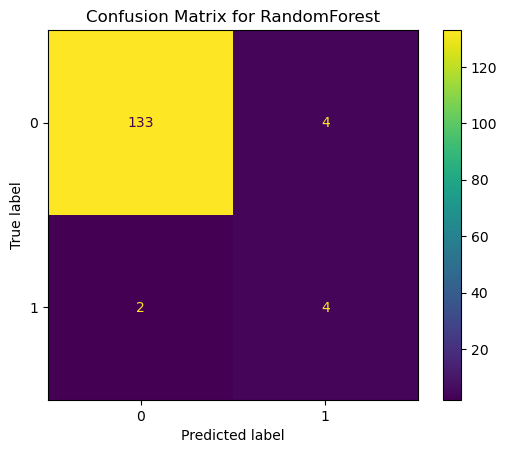


 Training XGBoost

Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__scale_pos_weight': np.float64(26.950000000000003)}
Balanced Accuracy: 0.9130

Classification Report:


,precision,recall,f1-score,support
0,0.992701,0.992701,0.992701,137.000000
1,0.833333,0.833333,0.833333,6.000000
accuracy,0.986014,0.986014,0.986014,0.986014
macro avg,0.913017,0.913017,0.913017,143.000000
weighted avg,0.986014,0.986014,0.986014,143.000000


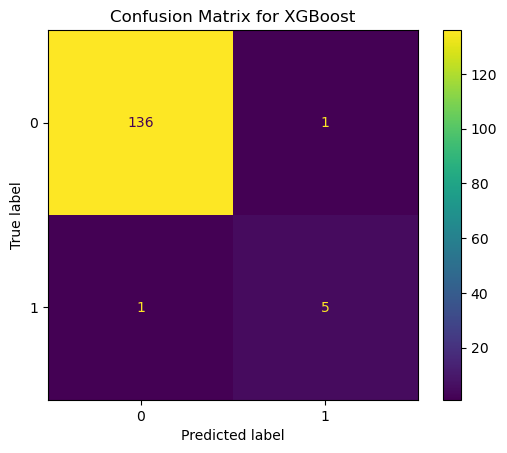

In [400]:

for name, (model, params) in models.items():
    print(f"\n=======================================================")
    print(f" Training {name}")
    print("=======================================================")

  
    if name == "XGBoost":
        
        pipeline = ImbPipeline(steps=[
            ("prep", preprocess),
            ("model", model)
        ])
    else:
       
        pipeline = ImbPipeline(steps=[
            ("prep", preprocess),
            ("smote", SMOTE(random_state=42)),
            ("model", model)
        ])

    clf = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        scoring="balanced_accuracy",
        cv=5,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    best_models[name] = clf

    y_pred = clf.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {
        'balanced_accuracy': bal_acc,
        'best_params': clf.best_params_,
        'report_df': pd.DataFrame(report_dict).T,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

       
    print(f"\nBest Params: {clf.best_params_}")
    print(f"Balanced Accuracy: {bal_acc:.4f}\n")

    
    print("Classification Report:")
    display(results[name]['report_df'])

   
    cm_display = ConfusionMatrixDisplay(confusion_matrix = results[name]['confusion_matrix'], display_labels = [0, 1])
    cm_display.plot()
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


# FINAL COMPARISON

In [401]:

print("\n\n=======================================================")
print(" FINAL MODEL SUMMARY")
print("=======================================================")

summary_data = {
    name: [res['balanced_accuracy'], res['report_df'].loc['macro avg', 'f1-score']]
    for name, res in results.items()
}
summary_df = pd.DataFrame(summary_data, index=['Balanced Accuracy', 'Macro F1-Score']).T

print("\nPerformance Overview:")
display(summary_df.sort_values(by='Balanced Accuracy', ascending=False))



 FINAL MODEL SUMMARY

Performance Overview:


,Balanced Accuracy,Macro F1-Score
XGBoost,0.913017,0.913017
RandomForest,0.818735,0.774685


# **Make Predictions with Test Set**



# **Predicting 2023-2024 UCL Winner**

In [402]:
cl_2023_24_r16_teams_group_stats = [
    {'Club': 'Real Madrid', 'matches_played': 6, 'wins': 6, 'Draw': 0, 'losses': 0, 'goals_scored': 16, 'goals_conceded': 7},
    {'Club': 'Manchester City', 'matches_played': 6, 'wins': 6, 'Draw': 0, 'losses': 0, 'goals_scored': 18, 'goals_conceded': 7},
    {'Club': 'Bayern Munich', 'matches_played': 6, 'wins': 5, 'Draw': 1, 'losses': 0, 'goals_scored': 12, 'goals_conceded': 6},
    {'Club': 'Atlético Madrid', 'matches_played': 6, 'wins': 4, 'Draw': 2, 'losses': 0, 'goals_scored': 17, 'goals_conceded': 6},
    {'Club': 'Arsenal', 'matches_played': 6, 'wins': 4, 'Draw': 1, 'losses': 1, 'goals_scored': 16, 'goals_conceded': 4},
    {'Club': 'Real Sociedad', 'matches_played': 6, 'wins': 3, 'Draw': 3, 'losses': 0, 'goals_scored': 7, 'goals_conceded': 2},
    {'Club': 'Inter Milan', 'matches_played': 6, 'wins': 3, 'Draw': 3, 'losses': 0, 'goals_scored': 8, 'goals_conceded': 5},
    {'Club': 'Barcelona', 'matches_played': 6, 'wins': 4, 'Draw': 0, 'losses': 2, 'goals_scored': 12, 'goals_conceded': 6},
    {'Club': 'Porto', 'matches_played': 6, 'wins': 4, 'Draw': 0, 'losses': 2, 'goals_scored': 15, 'goals_conceded': 8},
    {'Club': 'RB Leipzig', 'matches_played': 6, 'wins': 4, 'Draw': 0, 'losses': 2, 'goals_scored': 13, 'goals_conceded': 10},
    {'Club': 'Borussia Dortmund', 'matches_played': 6, 'wins': 3, 'Draw': 2, 'losses': 1, 'goals_scored': 7, 'goals_conceded': 4},
    {'Club': 'Napoli', 'matches_played': 6, 'wins': 3, 'Draw': 1, 'losses': 2, 'goals_scored': 10, 'goals_conceded': 9},
    {'Club': 'Lazio', 'matches_played': 6, 'wins': 3, 'Draw': 1, 'losses': 2, 'goals_scored': 7, 'goals_conceded': 7},
    {'Club': 'PSV Eindhoven', 'matches_played': 6, 'wins': 2, 'Draw': 3, 'losses': 1, 'goals_scored': 8, 'goals_conceded': 10},
    {'Club': 'Paris Saint-Germain', 'matches_played': 6, 'wins': 2, 'Draw': 2, 'losses': 2, 'goals_scored': 9, 'goals_conceded': 8},
    {'Club': 'Copenhagen', 'matches_played': 6, 'wins': 2, 'Draw': 2, 'losses': 2, 'goals_scored': 8, 'goals_conceded': 8}
]

df_cl_2023_24 = pd.DataFrame(cl_2023_24_r16_teams_group_stats)

df_cl_2023_24 = df_cl_2023_24.rename(columns={
    'Club': 'team',
    'Draw': 'draws',
    'matches_played': 'match_played',
    'losses': 'losts'
})

df_cl_2023_24["gd"] = df_cl_2023_24["goals_scored"] - df_cl_2023_24["goals_conceded"]
df_cl_2023_24["group_point"] = df_cl_2023_24["wins"] * 3 + df_cl_2023_24["draws"]


df_cl_2023_2024 = df_cl_2023_24.drop(columns=["team"])

print("\n2023-24 Round of 16 Feature Table Ready:")
print(df_cl_2023_2024.head())


2023-24 Round of 16 Feature Table Ready:
   match_played  wins  draws  losts  goals_scored  goals_conceded  gd  \
0             6     6      0      0            16               7   9   
1             6     6      0      0            18               7  11   
2             6     5      1      0            12               6   6   
3             6     4      2      0            17               6  11   
4             6     4      1      1            16               4  12   

   group_point  
0           18  
1           18  
2           16  
3           14  
4           13  


# Predicting with RandomForest

In [403]:

model_name = "RandomForest"
def predict_probabilities(input_df, model_name):
    
    model = best_models[model_name]
    return model.predict_proba(input_df)[:, 1]  

probs = predict_probabilities(df_cl_2023_2024, model_name)


results = pd.DataFrame({
    "team": df_cl_2023_24["team"],
    "win_probability": probs
})


results = results.sort_values(by="win_probability", ascending=False)

print("\n===== UCL 2023-24 ROUND OF 16 — WINNING PROBABILITIES =====\n")
results



===== UCL 2023-24 ROUND OF 16 — WINNING PROBABILITIES =====



,team,win_probability
3,Atlético Madrid,0.322804
0,Real Madrid,0.316565
1,Manchester City,0.304164
5,Real Sociedad,0.183951
2,Bayern Munich,0.176742
4,Arsenal,0.158579
6,Inter Milan,0.112853
10,Borussia Dortmund,0.015828
8,Porto,0.006192
7,Barcelona,0.005409


## ACTUAL 2023-24 UCL WINNER: 🏆🏆**Real Madrid**🏆🏆
## -------------------------------------------------------

<div style="text-align:center;">
    <img src="2024_winner.avif" alt="UCL 2024" width="800"/>
</div>

# Predicting with XGBoost

In [404]:

model_name = "XGBoost"
def predict_probabilities(input_df, model_name):
    
    model = best_models[model_name]
    return model.predict_proba(input_df)[:, 1]  

probs = predict_probabilities(df_cl_2023_2024, model_name)


results = pd.DataFrame({
    "team": df_cl_2023_24["team"],
    "win_probability": probs
})


results = results.sort_values(by="win_probability", ascending=False)

print("\n===== UCL 2023-24 ROUND OF 16 — WINNING PROBABILITIES =====\n")
results


===== UCL 2023-24 ROUND OF 16 — WINNING PROBABILITIES =====



,team,win_probability
3,Atlético Madrid,0.784622
0,Real Madrid,0.542990
1,Manchester City,0.316396
6,Inter Milan,0.171683
5,Real Sociedad,0.101222
2,Bayern Munich,0.050851
4,Arsenal,0.033872
10,Borussia Dortmund,0.003850
14,Paris Saint-Germain,0.001774
15,Copenhagen,0.001774


## ACTUAL 2023-24 UCL WINNER: 🏆🏆**Real Madrid**🏆🏆
## -------------------------------------------------------

<div style="text-align:center;">
    <img src="2024_winner.avif" alt="UCL 2024" width="800"/>
</div>

# **Predicting 2022-2023 UCL Winner**

In [405]:
cl_2022_23_r16_teams_group_stats = [
    {'Club': 'Bayern Munich', 'matches_played': 6, 'wins': 6, 'Draw': 0, 'losses': 0, 'goals_scored': 18, 'goals_conceded': 2},
    {'Club': 'Napoli', 'matches_played': 6, 'wins': 5, 'Draw': 0, 'losses': 1, 'goals_scored': 20, 'goals_conceded': 6},
    {'Club': 'Liverpool', 'matches_played': 6, 'wins': 5, 'Draw': 0, 'losses': 1, 'goals_scored': 17, 'goals_conceded': 6},
    {'Club': 'Manchester City', 'matches_played': 6, 'wins': 4, 'Draw': 2, 'losses': 0, 'goals_scored': 14, 'goals_conceded': 2},
    {'Club': 'Benfica', 'matches_played': 6, 'wins': 4, 'Draw': 2, 'losses': 0, 'goals_scored': 16, 'goals_conceded': 7},
    {'Club': 'Paris Saint-Germain', 'matches_played': 6, 'wins': 4, 'Draw': 2, 'losses': 0, 'goals_scored': 16, 'goals_conceded': 7},
    {'Club': 'Chelsea', 'matches_played': 6, 'wins': 4, 'Draw': 1, 'losses': 1, 'goals_scored': 10, 'goals_conceded': 4},
    {'Club': 'Real Madrid', 'matches_played': 6, 'wins': 4, 'Draw': 1, 'losses': 1, 'goals_scored': 15, 'goals_conceded': 6},
    {'Club': 'Porto', 'matches_played': 6, 'wins': 4, 'Draw': 0, 'losses': 2, 'goals_scored': 12, 'goals_conceded': 7},
    {'Club': 'RB Leipzig', 'matches_played': 6, 'wins': 4, 'Draw': 0, 'losses': 2, 'goals_scored': 13, 'goals_conceded': 9},
    {'Club': 'Club Brugge', 'matches_played': 6, 'wins': 3, 'Draw': 2, 'losses': 1, 'goals_scored': 7, 'goals_conceded': 4},
    {'Club': 'Tottenham Hotspur', 'matches_played': 6, 'wins': 3, 'Draw': 2, 'losses': 1, 'goals_scored': 8, 'goals_conceded': 6},
    {'Club': 'Inter Milan', 'matches_played': 6, 'wins': 3, 'Draw': 1, 'losses': 2, 'goals_scored': 10, 'goals_conceded': 7},
    {'Club': 'Eintracht Frankfurt', 'matches_played': 6, 'wins': 3, 'Draw': 1, 'losses': 2, 'goals_scored': 7, 'goals_conceded': 8},
    {'Club': 'AC Milan', 'matches_played': 6, 'wins': 3, 'Draw': 1, 'losses': 2, 'goals_scored': 12, 'goals_conceded': 7},
    {'Club': 'Borussia Dortmund', 'matches_played': 6, 'wins': 2, 'Draw': 3, 'losses': 1, 'goals_scored': 10, 'goals_conceded': 5}
]

df_cl_2022_23 = pd.DataFrame(cl_2022_23_r16_teams_group_stats)
df_cl_2022_23 = df_cl_2022_23.rename(columns={
    'Club': 'team',
    'Draw': 'draws',
    'matches_played': 'match_played',
    'losses': 'losts'
})

df_cl_2022_23["gd"] = df_cl_2022_23["goals_scored"] - df_cl_2022_23["goals_conceded"]
df_cl_2022_23["group_point"] = df_cl_2022_23["wins"] * 3 + df_cl_2022_23["draws"]


df_cl_2022_2023 = df_cl_2022_23.drop(columns=["team"])

print("\n2022-23 Round of 16 Feature Table Ready:")
print(df_cl_2022_2023.head())


2022-23 Round of 16 Feature Table Ready:
   match_played  wins  draws  losts  goals_scored  goals_conceded  gd  \
0             6     6      0      0            18               2  16   
1             6     5      0      1            20               6  14   
2             6     5      0      1            17               6  11   
3             6     4      2      0            14               2  12   
4             6     4      2      0            16               7   9   

   group_point  
0           18  
1           15  
2           15  
3           14  
4           14  


# Predicting with RandomForest

In [406]:

model_name = "RandomForest"
def predict_probabilities(input_df, model_name):
    
    model = best_models[model_name]
    return model.predict_proba(input_df)[:, 1]  

probs = predict_probabilities(df_cl_2022_2023, model_name)


results = pd.DataFrame({
    "team": df_cl_2022_23["team"],
    "win_probability": probs
})


results = results.sort_values(by="win_probability", ascending=False)

print("\n===== UCL 2022-23 ROUND OF 16 — WINNING PROBABILITIES =====\n")
results


===== UCL 2022-23 ROUND OF 16 — WINNING PROBABILITIES =====



,team,win_probability
3,Manchester City,0.432362
0,Bayern Munich,0.402437
4,Benfica,0.252213
5,Paris Saint-Germain,0.252213
1,Napoli,0.119243
2,Liverpool,0.098248
7,Real Madrid,0.042124
6,Chelsea,0.018429
10,Club Brugge,0.015828
15,Borussia Dortmund,0.006749


## ACTUAL 2022-23 UCL WINNER: 🏆🏆**Manchester City**🏆🏆
## ------------------------------------------------------------

<div style="text-align:center;">
    <img src="2023_winner.jpeg" alt="UCL 2024" width="800"/>
</div>

# Predicting with XGBoost

In [407]:


model_name = "XGBoost"
def predict_probabilities(input_df, model_name):
    
    model = best_models[model_name]
    return model.predict_proba(input_df)[:, 1]  

probs = predict_probabilities(df_cl_2022_2023, model_name)


results = pd.DataFrame({
    "team": df_cl_2022_23["team"],
    "win_probability": probs
})


results = results.sort_values(by="win_probability", ascending=False)

print("\n===== UCL 2022-23 ROUND OF 16 — WINNING PROBABILITIES =====\n")
results


===== UCL 2022-23 ROUND OF 16 — WINNING PROBABILITIES =====



,team,win_probability
3,Manchester City,0.788776
4,Benfica,0.724603
5,Paris Saint-Germain,0.724603
0,Bayern Munich,0.220377
7,Real Madrid,0.039800
10,Club Brugge,0.003850
11,Tottenham Hotspur,0.003850
2,Liverpool,0.003824
9,RB Leipzig,0.003212
12,Inter Milan,0.001321


## ACTUAL 2022-23 UCL WINNER: 🏆🏆**Manchester City**🏆🏆
## ------------------------------------------------------------

<div style="text-align:center;">
    <img src="2023_winner.jpeg" alt="UCL 2024" width="800"/>
</div>

# **Predicting 2021-2022 UCL Winner**

In [408]:
cl_2021_22_r16_teams_group_stats = [
    {'Club': 'Liverpool', 'matches_played': 6, 'wins': 6, 'Draw': 0, 'losses': 0, 'goals_scored': 17, 'goals_conceded': 6},
    {'Club': 'Ajax', 'matches_played': 6, 'wins': 6, 'Draw': 0, 'losses': 0, 'goals_scored': 20, 'goals_conceded': 5},
    {'Club': 'Bayern Munich', 'matches_played': 6, 'wins': 6, 'Draw': 0, 'losses': 0, 'goals_scored': 22, 'goals_conceded': 3},
    {'Club': 'Real Madrid', 'matches_played': 6, 'wins': 5, 'Draw': 0, 'losses': 1, 'goals_scored': 14, 'goals_conceded': 3},
    {'Club': 'Juventus', 'matches_played': 6, 'wins': 5, 'Draw': 0, 'losses': 1, 'goals_scored': 10, 'goals_conceded': 6},
    {'Club': 'Manchester City', 'matches_played': 6, 'wins': 4, 'Draw': 0, 'losses': 2, 'goals_scored': 18, 'goals_conceded': 10},
    {'Club': 'Chelsea', 'matches_played': 6, 'wins': 4, 'Draw': 1, 'losses': 1, 'goals_scored': 13, 'goals_conceded': 4},
    {'Club': 'Manchester United', 'matches_played': 6, 'wins': 3, 'Draw': 2, 'losses': 1, 'goals_scored': 11, 'goals_conceded': 8},
    {'Club': 'Lille', 'matches_played': 6, 'wins': 3, 'Draw': 2, 'losses': 1, 'goals_scored': 7, 'goals_conceded': 4},
    {'Club': 'Paris Saint-Germain', 'matches_played': 6, 'wins': 3, 'Draw': 2, 'losses': 1, 'goals_scored': 13, 'goals_conceded': 8},
    {'Club': 'Inter Milan', 'matches_played': 6, 'wins': 3, 'Draw': 1, 'losses': 2, 'goals_scored': 8, 'goals_conceded': 5},
    {'Club': 'Salzburg', 'matches_played': 6, 'wins': 3, 'Draw': 1, 'losses': 2, 'goals_scored': 8, 'goals_conceded': 6},
    {'Club': 'Villarreal', 'matches_played': 6, 'wins': 3, 'Draw': 1, 'losses': 2, 'goals_scored': 12, 'goals_conceded': 9},
    {'Club': 'Sporting CP', 'matches_played': 6, 'wins': 3, 'Draw': 0, 'losses': 3, 'goals_scored': 14, 'goals_conceded': 12},
    {'Club': 'Benfica', 'matches_played': 6, 'wins': 2, 'Draw': 2, 'losses': 2, 'goals_scored': 7, 'goals_conceded': 9},
    {'Club': 'Atlético Madrid', 'matches_played': 6, 'wins': 2, 'Draw': 1, 'losses': 3, 'goals_scored': 7, 'goals_conceded': 8}
]

df_cl_2021_22 = pd.DataFrame(cl_2021_22_r16_teams_group_stats)
df_cl_2021_22 = df_cl_2021_22.rename(columns={
    'Club': 'team',
    'Draw': 'draws',
    'matches_played': 'match_played',
    'losses': 'losts'
})

df_cl_2021_22["gd"] = df_cl_2021_22["goals_scored"] - df_cl_2021_22["goals_conceded"]
df_cl_2021_22["group_point"] = df_cl_2021_22["wins"] * 3 + df_cl_2021_22["draws"]


df_cl_2021_2022 = df_cl_2021_22.drop(columns=["team"])

print("\n2021-22 Round of 16 Feature Table Ready:")
print(df_cl_2021_2022.head())



2021-22 Round of 16 Feature Table Ready:
   match_played  wins  draws  losts  goals_scored  goals_conceded  gd  \
0             6     6      0      0            17               6  11   
1             6     6      0      0            20               5  15   
2             6     6      0      0            22               3  19   
3             6     5      0      1            14               3  11   
4             6     5      0      1            10               6   4   

   group_point  
0           18  
1           18  
2           18  
3           15  
4           15  


# Predicting with RandomForest

In [409]:

model_name = "RandomForest"
def predict_probabilities(input_df, model_name):
    
    model = best_models[model_name]
    return model.predict_proba(input_df)[:, 1]  

probs = predict_probabilities(df_cl_2021_2022, model_name)


results = pd.DataFrame({
    "team": df_cl_2021_22["team"],
    "win_probability": probs
})


results = results.sort_values(by="win_probability", ascending=False)

print("\n===== UCL 2021-22 ROUND OF 16 — WINNING PROBABILITIES =====\n")
results


===== UCL 2021-22 ROUND OF 16 — WINNING PROBABILITIES =====



,team,win_probability
2,Bayern Munich,0.391505
1,Ajax,0.324818
0,Liverpool,0.313837
3,Real Madrid,0.178337
4,Juventus,0.062659
6,Chelsea,0.055010
5,Manchester City,0.028960
8,Lille,0.015828
9,Paris Saint-Germain,0.009905
7,Manchester United,0.007650


## ACTUAL 2021-22 UCL WINNER: 🏆🏆**Real Madrid**🏆🏆
## ------------------------------------------------------

<div style="text-align:center;">
    <img src="2022_winner.webp" alt="UCL 2024" width="800"/>
</div>

# Predicting with XGBoost

In [410]:

model_name = "XGBoost"
def predict_probabilities(input_df, model_name):
    
    model = best_models[model_name]
    return model.predict_proba(input_df)[:, 1]  

probs = predict_probabilities(df_cl_2021_2022, model_name)


results = pd.DataFrame({
    "team": df_cl_2021_22["team"],
    "win_probability": probs
})


results = results.sort_values(by="win_probability", ascending=False)

print("\n===== UCL 2021-22 ROUND OF 16 — WINNING PROBABILITIES =====\n")
results




===== UCL 2021-22 ROUND OF 16 — WINNING PROBABILITIES =====



,team,win_probability
0,Liverpool,0.621938
2,Bayern Munich,0.559593
1,Ajax,0.177048
6,Chelsea,0.045183
7,Manchester United,0.004714
8,Lille,0.003850
9,Paris Saint-Germain,0.001816
14,Benfica,0.001789
3,Real Madrid,0.001758
5,Manchester City,0.001609


## ACTUAL 2021-22 UCL WINNER: 🏆🏆**Real Madrid**🏆🏆
## ------------------------------------------------------

<div style="text-align:center;">
    <img src="2022_winner.webp" alt="UCL 2024" width="800"/>
</div>

# **Predicting 2020-2021 UCL Winner**

In [411]:
cl_2020_21_r16_teams_group_stats = [
    {'Club': 'Bayern Munich', 'matches_played': 6, 'wins': 5, 'Draw': 1, 'losses': 0, 'goals_scored': 18, 'goals_conceded': 5},
    {'Club': 'Manchester City', 'matches_played': 6, 'wins': 5, 'Draw': 1, 'losses': 0, 'goals_scored': 13, 'goals_conceded': 1},
    {'Club': 'Liverpool', 'matches_played': 6, 'wins': 4, 'Draw': 1, 'losses': 1, 'goals_scored': 10, 'goals_conceded': 3},
    {'Club': 'Chelsea', 'matches_played': 6, 'wins': 4, 'Draw': 2, 'losses': 0, 'goals_scored': 14, 'goals_conceded': 2},
    {'Club': 'Dortmund', 'matches_played': 6, 'wins': 4, 'Draw': 1, 'losses': 1, 'goals_scored': 12, 'goals_conceded': 5},
    {'Club': 'Juventus', 'matches_played': 6, 'wins': 5, 'Draw': 0, 'losses': 1, 'goals_scored': 13, 'goals_conceded': 4},
    {'Club': 'Paris Saint-Germain', 'matches_played': 6, 'wins': 4, 'Draw': 0, 'losses': 2, 'goals_scored': 13, 'goals_conceded': 6},
    {'Club': 'Real Madrid', 'matches_played': 6, 'wins': 3, 'Draw': 1, 'losses': 2, 'goals_scored': 11, 'goals_conceded': 9},
    {'Club': 'Atlético Madrid', 'matches_played': 6, 'wins': 2, 'Draw': 3, 'losses': 1, 'goals_scored': 7, 'goals_conceded': 5},
    {'Club': 'Lazio', 'matches_played': 6, 'wins': 2, 'Draw': 3, 'losses': 1, 'goals_scored': 7, 'goals_conceded': 5},
    {'Club': 'Porto', 'matches_played': 6, 'wins': 4, 'Draw': 1, 'losses': 1, 'goals_scored': 10, 'goals_conceded': 3},
    {'Club': 'Sevilla', 'matches_played': 6, 'wins': 4, 'Draw': 1, 'losses': 1, 'goals_scored': 9, 'goals_conceded': 8},
    {'Club': 'Leipzig', 'matches_played': 6, 'wins': 4, 'Draw': 0, 'losses': 2, 'goals_scored': 11, 'goals_conceded': 12},
    {'Club': 'Atalanta', 'matches_played': 6, 'wins': 3, 'Draw': 2, 'losses': 1, 'goals_scored': 10, 'goals_conceded': 8},
    {'Club': 'Monchengladbach', 'matches_played': 6, 'wins': 2, 'Draw': 2, 'losses': 2, 'goals_scored': 16, 'goals_conceded': 9},
    {'Club': 'Barcelona', 'matches_played': 6, 'wins': 5, 'Draw': 0, 'losses': 1, 'goals_scored': 16, 'goals_conceded': 5}
]


df_cl_2020_21 = pd.DataFrame(cl_2020_21_r16_teams_group_stats)


df_cl_2020_21 = df_cl_2020_21.rename(columns={
    'Club': 'team',
    'Draw': 'draws',
    'matches_played': 'match_played',
    'losses': 'losts'
})


df_cl_2020_21["gd"] = df_cl_2020_21["goals_scored"] - df_cl_2020_21["goals_conceded"]


df_cl_2020_21["group_point"] = df_cl_2020_21["wins"] * 3 + df_cl_2020_21["draws"]


df_cl_2020_2021 = df_cl_2020_21.drop(columns=["team"])

print("2020-21 Round of 16 Feature Table Ready:")
print(df_cl_2020_2021.head())

2020-21 Round of 16 Feature Table Ready:
   match_played  wins  draws  losts  goals_scored  goals_conceded  gd  \
0             6     5      1      0            18               5  13   
1             6     5      1      0            13               1  12   
2             6     4      1      1            10               3   7   
3             6     4      2      0            14               2  12   
4             6     4      1      1            12               5   7   

   group_point  
0           16  
1           16  
2           13  
3           14  
4           13  


# Predicting with RandomForest

In [412]:

model_name = "RandomForest"
def predict_probabilities(input_df, model_name):
    
    model = best_models[model_name]
    return model.predict_proba(input_df)[:, 1]  

probs = predict_probabilities(df_cl_2020_2021, model_name)


results = pd.DataFrame({
    "team": df_cl_2020_21["team"],
    "win_probability": probs
})


results = results.sort_values(by="win_probability", ascending=False)

print("\n===== UCL 2020-21 ROUND OF 16 — WINNING PROBABILITIES =====\n")
results


===== UCL 2020-21 ROUND OF 16 — WINNING PROBABILITIES =====



,team,win_probability
3,Chelsea,0.432362
1,Manchester City,0.397464
0,Bayern Munich,0.344075
15,Barcelona,0.141027
5,Juventus,0.093166
2,Liverpool,0.034807
10,Porto,0.034807
14,Monchengladbach,0.032215
4,Dortmund,0.013379
11,Sevilla,0.010218


## ACTUAL 2020-21 UCL WINNER: 🏆🏆**Chelsea**🏆🏆
## --------------------------------------------------

<div style="text-align:center;">
    <img src="2021_winner.jpg" alt="UCL 2024" width="800"/>
</div>

# Predicting with XGBoost

In [413]:

model_name = "XGBoost"
def predict_probabilities(input_df, model_name):
    
    model = best_models[model_name]
    return model.predict_proba(input_df)[:, 1]  

probs = predict_probabilities(df_cl_2020_2021, model_name)


results = pd.DataFrame({
    "team": df_cl_2020_21["team"],
    "win_probability": probs
})


results = results.sort_values(by="win_probability", ascending=False)

print("\n===== UCL 2020-21 ROUND OF 16 — WINNING PROBABILITIES =====\n")
results




===== UCL 2020-21 ROUND OF 16 — WINNING PROBABILITIES =====



,team,win_probability
3,Chelsea,0.788776
1,Manchester City,0.655089
0,Bayern Munich,0.476175
11,Sevilla,0.005526
13,Atalanta,0.004714
8,Atlético Madrid,0.003998
9,Lazio,0.003998
5,Juventus,0.002372
15,Barcelona,0.001758
7,Real Madrid,0.001332


## ACTUAL 2020-21 UCL WINNER: 🏆🏆**Chelsea**🏆🏆
## --------------------------------------------------

<div style="text-align:center;">
    <img src="2021_winner.jpg" alt="UCL 2024" width="800"/>
</div>